---
## Import Libraries

In [178]:
import yfinance as yf
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

---
## Parameters

In [179]:
period_start= "2014-01-01"
period_end= "2020-01-01"
interval_input = "5d"
ticker_input = "PHYS"

---
## Data Pre-processing


In [180]:

#Input:
#   ticker: The stock ticker (eg. NVDA) to specify the stock to be analyzed
#   period_start, period_end: The start and end point to grab data from. Format : "<year>-<month>-<day>"
#   interval_input: The time intervals between the values used: (“1m”, “2m”, “5m”, “15m”, “30m”, “60m”, “90m”, “1h”, “1d”, “5d”, “1wk”, “1mo”, “3mo”)

def gather_data(ticker,period_start, period_end, interval_input):


  ticker_histdata = (yf.Ticker(ticker_input)).history(start=period_start, end=period_end, interval=interval_input)
  df_ticker_histdata = pd.DataFrame(ticker_histdata)
  closeprices = df_ticker_histdata['Close']
  mean_stockprice = closeprices.mean()
  sdev_stockprice = closeprices.std()

  return [closeprices, mean_stockprice, sdev_stockprice]

#initialize closeprices, mean_stockprice, sdev_stockprice
closeprices, mean_stockprice, sdev_stockprice = gather_data(ticker_input,period_start, period_end, interval_input)


#------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# 1) establish variables to store raw, sorted and formatted variants of pct changes
# (e.g. displayable 2% rather than 0.02 on x-axis)


def compute_weekly_pct_changes(closeprices):


  # calculate pct changes with for loop
  pct_change_list = pd.Series([((closeprices.iloc[i+1] / closeprices.iloc[i])) for i in range(len(closeprices)-1)])
  formatted_pct_change_list = pd.Series([round(((pct_change_list.iloc[i]-1)*100),2) for i in range(len(pct_change_list))])
  sorted_pct_change_list = pct_change_list.sort_values(ascending=True)

  mean_pct_change = pct_change_list.mean()
  sdev_pct_change = pct_change_list.std()

  # establish euler number to calculate for lognormal distribution
  euler_number = 2.71828

  mean_pct_change_lognormal = euler_number ** (mean_pct_change + ((sdev_pct_change**2)/2))
  sdev_pct_change_lognormal = mean_pct_change_lognormal * math.sqrt((euler_number ** (sdev_pct_change**2))-1)

  return [pct_change_list, sorted_pct_change_list, formatted_pct_change_list,mean_pct_change, sdev_pct_change, mean_pct_change_lognormal, sdev_pct_change_lognormal]

pct_change_list, sorted_pct_change_list, formatted_pct_change_list,mean_pct_change, sdev_pct_change, mean_pct_change_lognormal, sdev_pct_change_lognormal = compute_weekly_pct_changes(closeprices)



#------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Distrubution of Close Prices

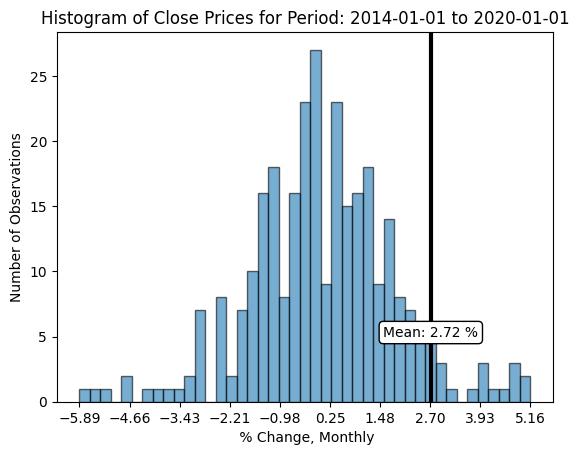

In [181]:

def plot_results(arr):

    # Use Freedman-Diaconis rule to identify appropriate bin sizing
    inter_quantile_range = arr.quantile(0.75) - arr.quantile(0.25)
    bins_width = 2 * (inter_quantile_range / math.sqrt(len(arr)))
    bins_num = int((np.max(arr) - np.min(arr)) / bins_width)

    plt.hist(arr, bins=(bins_num), edgecolor='black', alpha=0.6)  # Set edgecolor here
    plt.title(f'Histogram of Close Prices for Period: {period_start} to {period_end}')
    text_background_formatting = dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')

    plt.xlabel(' % Change, Monthly')
    plt.xticks(np.linspace(np.min(arr), np.max(arr), num=10))
    plt.ylabel('Number of Observations')


    # plot lognormal mean
    plt.axvline(mean_pct_change_lognormal, linewidth=3, color='black')
    plt.text(mean_pct_change_lognormal,5,f'Mean: {mean_pct_change_lognormal:.2f} %', bbox=text_background_formatting, ha='center')
    # plot lower and upper bollinger bands (set at +/- 2sdev)

    plt.show()

# CALL FUNCTION LINE:
plot_results(formatted_pct_change_list)


In [182]:
# Function to calculate the rolling average of the previous n data points
# uses as all available data existing data if fewer than n points are available
def rolling_average(arr, n):

    avg_list = []

    for i in range(len(arr)):
        if i < n:
            avg = round(arr.iloc[:i+1].mean(), 2)  # Use available data if less than n points
        else:
            avg = round(arr.iloc[i-n+1:i+1].mean(), 2)  # Use the last n points
        avg_list.append(avg)

    return avg_list


lookback_parameter = 3
avg_list = rolling_average(closeprices, lookback_parameter)




## Compute Bollinger Bands

In [183]:
import pandas as pd

def bog(arr, s=2, lookback_period=20):
    BOGGY_BANDS = pd.DataFrame()

    # Calculate the middle band (SMA), using as much data as available if less than the lookback period
    BOGGY_BANDS['Middle Band'] = arr.rolling(window=lookback_period, min_periods=1).mean()

    # Calculate the rolling standard deviation, using as much data as available if less than the lookback period
    rolling_std = arr.rolling(window=lookback_period, min_periods=1).std()

    # Calculate the upper band
    BOGGY_BANDS['Upper Band'] = BOGGY_BANDS['Middle Band'] + (s * rolling_std)

    # Calculate the lower band
    BOGGY_BANDS['Lower Band'] = BOGGY_BANDS['Middle Band'] - (s * rolling_std)

    # Calculate which action to take (CHAT GPT code)
    BOGGY_BANDS['Action'] = np.where(
        closeprices > BOGGY_BANDS['Upper Band'], -1,
        np.where(closeprices < BOGGY_BANDS['Lower Band'], 1, 0)
        )

    return BOGGY_BANDS


bog(closeprices)






,Middle Band,Upper Band,Lower Band,Action
Date,,,,
2014-01-06 00:00:00-05:00,10.270000,NaN,NaN,0
2014-01-16 00:00:00-05:00,10.305000,10.403995,10.206006,0
2014-01-21 00:00:00-05:00,10.316667,10.397496,10.235838,0
2014-01-31 00:00:00-05:00,10.332500,10.423969,10.241031,0
2014-02-05 00:00:00-05:00,10.360000,10.506288,10.213713,0
...,...,...,...,...
2019-12-06 00:00:00-05:00,11.903500,12.423227,11.383772,0
2019-12-11 00:00:00-05:00,11.921000,12.395171,11.446829,0
2019-12-16 00:00:00-05:00,11.941000,12.356282,11.525718,0


## Visualize Bollinger Bands

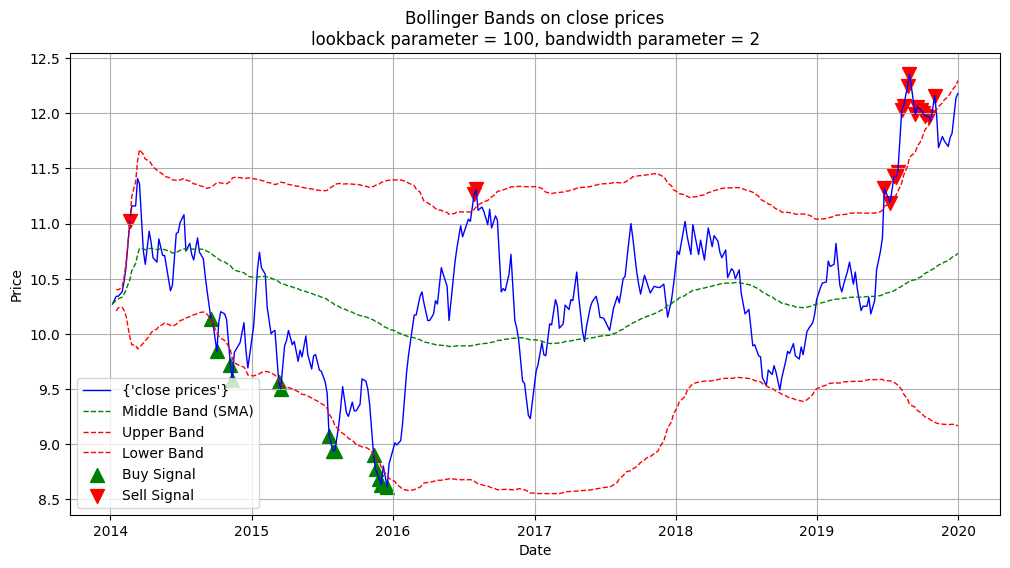

In [187]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def BOGGY_PLOT(closeprices, boggy_bands,data_type = "rolling average",lookback_parameter=20,s=2, ):
    plt.figure(figsize=(12, 6))

    # Plot close prices
    plt.plot(closeprices,label = {data_type}, color='blue', linewidth=1)

    # Plot Bollinger Bands
    plt.plot(boggy_bands['Middle Band'], label='Middle Band (SMA)', color='green', linestyle='--', linewidth=1)
    plt.plot(boggy_bands['Upper Band'], label='Upper Band', color='red', linestyle='--', linewidth=1)
    plt.plot(boggy_bands['Lower Band'], label='Lower Band', color='red', linestyle='--', linewidth=1)

    # Indicate actions on the plot
    buy_signals = boggy_bands['Action'] == 1
    sell_signals = boggy_bands['Action'] == -1

    plt.scatter(boggy_bands.index[buy_signals], closeprices[buy_signals], marker='^', color='green', label='Buy Signal', s=100)
    plt.scatter(boggy_bands.index[sell_signals], closeprices[sell_signals], marker='v', color='red', label='Sell Signal', s=100)

    # Adding labels and title
    plt.title(f"Bollinger Bands on {data_type}\nlookback parameter = {lookback_parameter}, bandwidth parameter = {s}")

    plt.xlabel('Date')
    plt.ylabel('Price')

    # Display legend
    plt.legend(loc='best')

    # Show grid for better readability
    plt.grid(True)

    # Show the plot
    plt.show()


p = 100
bog_bands = bog(closeprices,lookback_period=p,s =2)
BOGGY_PLOT(closeprices, bog_bands, "close prices",lookback_parameter=p, s = 2)





## Band Width Test

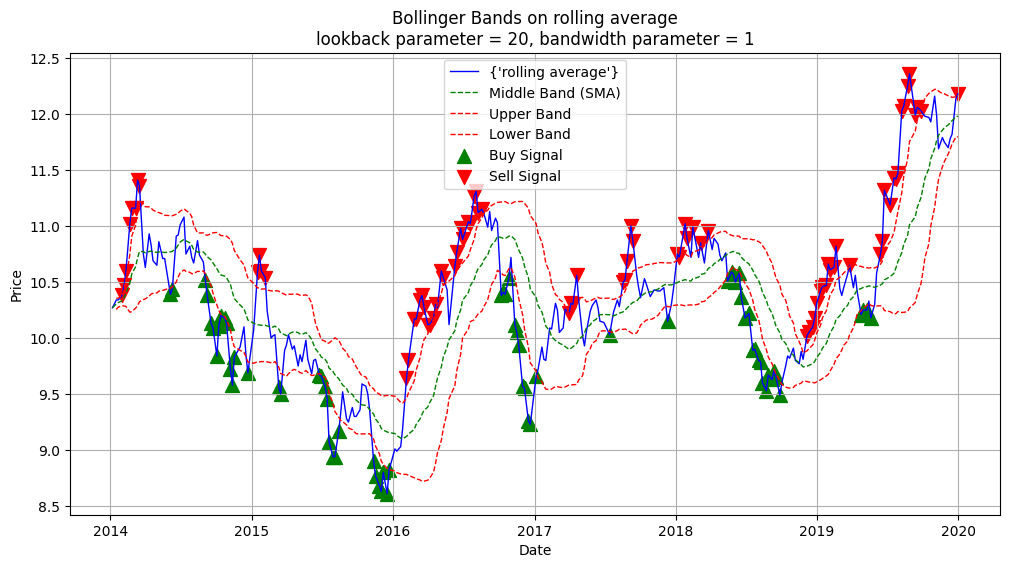

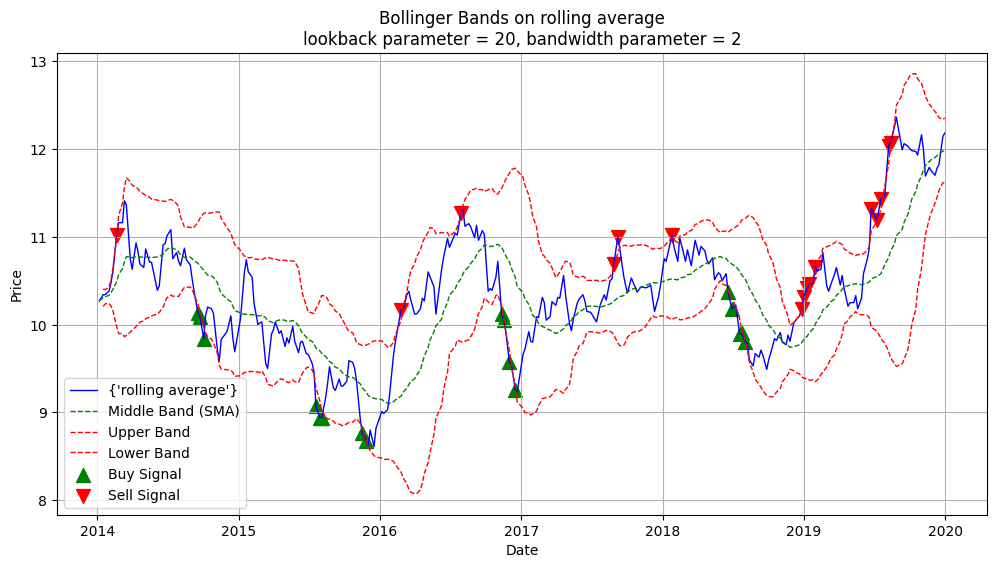

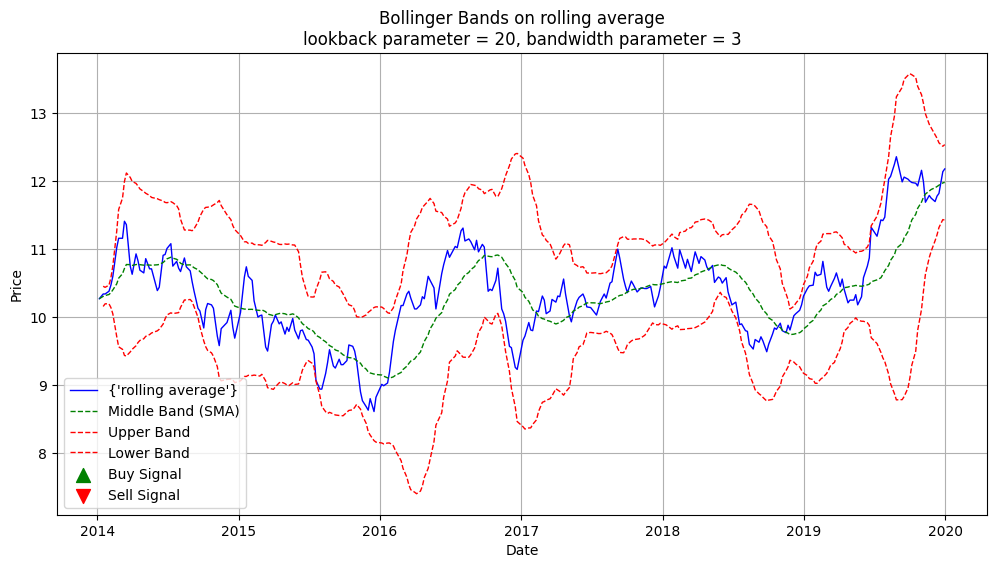

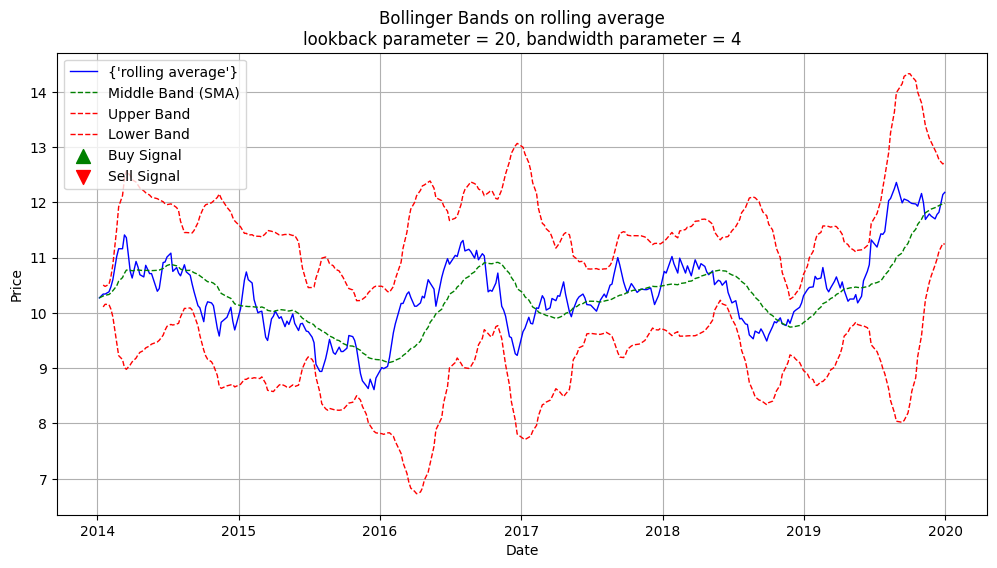

In [185]:
for b in range(1,5):
  bog_bands = bog(closeprices,lookback_period=20,s = b)
  BOGGY_PLOT(closeprices, bog_bands,lookback_parameter  = 20, s = b)

Look Back Test

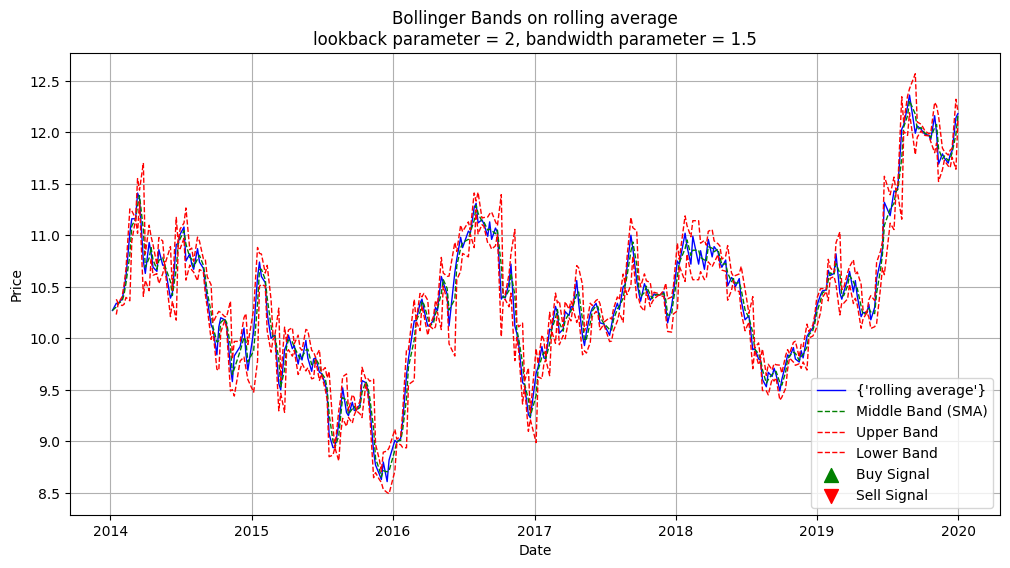

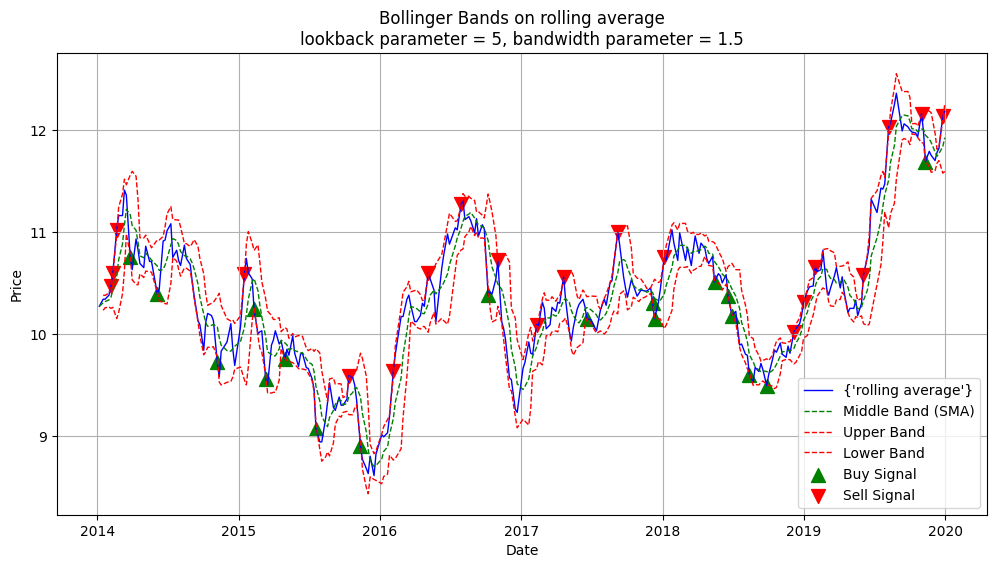

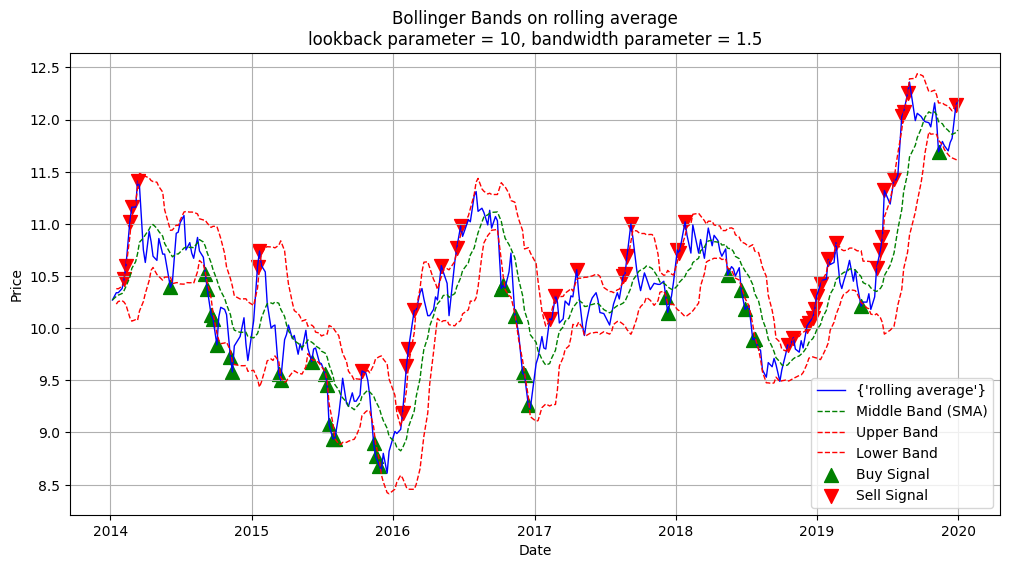

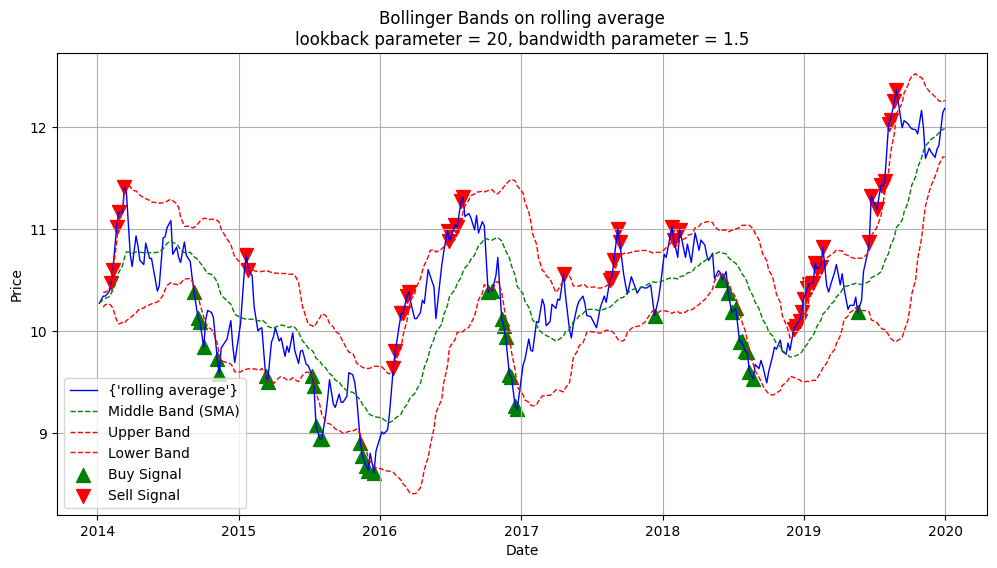

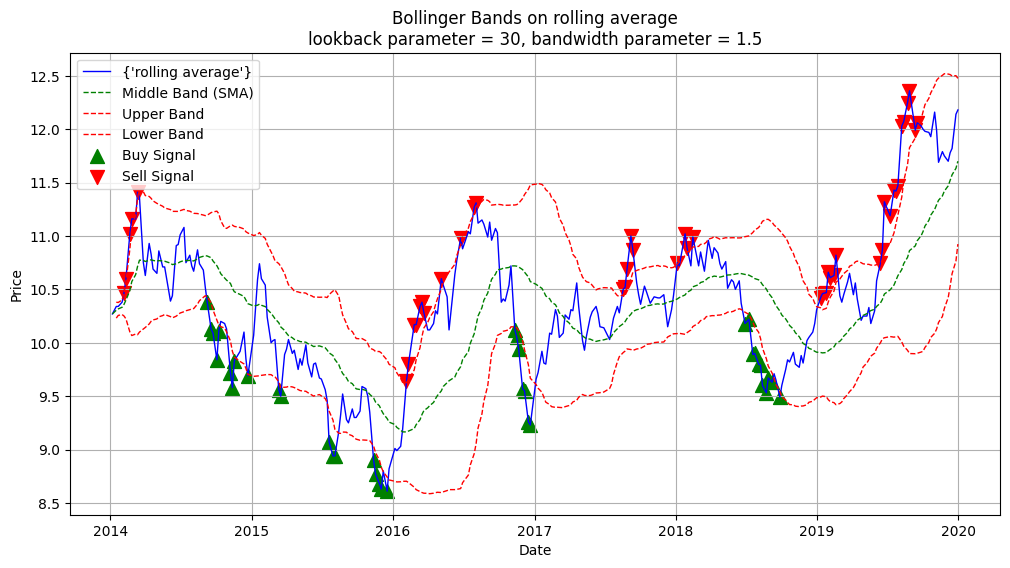

In [186]:
for look in [2,5,10,20,30]:
  bog_bands = bog(closeprices,lookback_period=look,s = 1.5)
  BOGGY_PLOT(closeprices, bog_bands,lookback_parameter  = look, s = 1.5)